# IMBD Sentimental Analysis Review

El siguiente proyecto tiene como objetivo la aplicación de técnicas de NLP para realizar un análisis de sentimientos sobre un dataset formado por reviews de diferentes películas de la base de datos IMBD. Todas ellas vienen correctamente tagueadas con su correspondiente sentimiento, positivo o negativo.

# Índice

**[0. Librerias](#heading--1)**

**[1. Carga de Datos](#heading--2)**

**[2. Análisis Exploratorio](#heading--3)**

**[3. PreProcesado](#heading--4)**

**[4. División de Datos](#heading--5)**

**[5. Tokenización de Datos](#heading--6)**

**[6. Modelos](#heading--7)**

  * [6.1. Red Neuronal Simple](#heading--7-1)
  
  * [6.2. CNN](#heading--7-2)

  * [6.2. RNN + CNN](#heading--7-3)

  * [6.4. LTSM](#heading--7-4)
  
**[7. Transformers](#heading--8)**

**[8. Comparación](#heading--9)**

**[9. Lineas de Investigación](#heading--10)**



<div id="heading--1"/>

## 0. Librerias

Importamos los paquetes que necesitaremos para poder trabajar:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import nltk
import wordcloud
import matplotlib
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras import layers

<div id="heading--2"/>

## 1. Carga de datos

La siguiente parte solo será necesaria si se trabaja desde Google Colab, además las rutas se deberán cambiar.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
cd ./drive/MyDrive/IMBD_Project

/content/drive/MyDrive/IMBD_Project


Una vez ya hemos configurado la entrada y carga de datos de Google Drive lo que haremos será cargar los datos con los que trabajaremos. Estos serán un csv formado por las reviews y su tag en cuanto al sentimiento.

In [15]:
reviews = pd.read_csv("./IMBD_data.csv")

In [16]:
reviews

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


A su vez cargaremos también los datos de las stop words, en inglés ya que las reviews están en inglés:

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stopwords = set(stopwords.words('english'))

In [19]:
print(stopwords)

{'d', 'my', "you've", 're', 'don', 'wouldn', 'ma', 'only', 'it', 'very', 'what', 'above', "isn't", 'not', 'wasn', 'be', 'about', 'him', 'other', 'their', 'as', 'between', 'with', 'again', "needn't", 'if', "wouldn't", 'hers', "you're", "you'll", 'were', 'having', "weren't", 'whom', 'or', 'hadn', 'he', 'here', 'doesn', "hasn't", 'over', "doesn't", 'into', 'same', 'from', 've', 's', 'after', 'hasn', 'both', 'himself', 'had', 'nor', "wasn't", "shan't", 'no', 'this', 'against', 'couldn', 'mustn', 'has', 'to', 'down', 'its', 'before', 'in', 'ourselves', "won't", 'few', 'shouldn', 'too', 'for', 'and', 'so', 'through', 'because', 'under', 'i', 'the', 'needn', 'there', 'myself', 'your', 'at', 'where', "that'll", 'ours', 'do', "shouldn't", 'aren', "she's", 'yourselves', 'during', 'doing', 'itself', 'out', 'off', "couldn't", 'does', 'but', 'further', 'some', 'o', 'then', 'just', 'won', 'how', "hadn't", 'isn', "aren't", 'you', 'of', 'her', 'until', 'them', 'themselves', 'they', 'these', 'did', "it

<div id="heading--3"/>

## 2. Análisis Exploratorio

Veamos si nuestros datos estan balanceados:

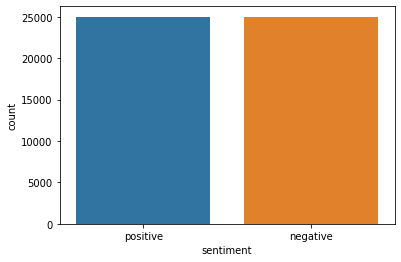

In [20]:
sns.countplot(x = "sentiment", data = reviews)

A continuación realizaremos un análisis de las palabras:

In [21]:
def get_word_tokens(sentences):
    words = []
    for sent in sentences:
        words.extend(word_tokenize(sent))
    print(words)
    return(words)

Pasamos las reviews a una lista para poder trabajar con ello:

In [22]:
reviews_lista = list(reviews['review'])

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [25]:
review_words = get_word_tokens(reviews_lista)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [27]:
matplotlib.use('TkAgg')

Creamos una función que nos saque una distribución de frecuencias de las diferentes palabras.

In [28]:
def plot_freq_dist(words, num_words = 20):
    fdist = FreqDist(words)
    fdist.plot(num_words,cumulative=False)

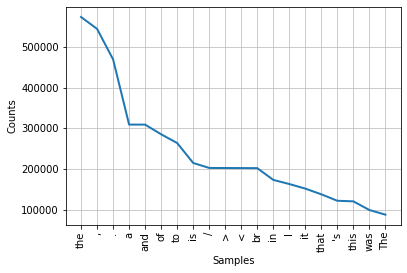

In [29]:
plot_freq_dist(review_words, num_words=20)

Como es facilmente observable la gran mayoria de palabras que más se repiten o son algunas incluidas en las stop words o son símbolos debidos a la técnica usada para obtener los datos. Para verlo correctamente tendremos que hacer un preprocesado.

In [30]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [31]:
def get_pos_tags(words):
    tags=[]
    for word in words:
        tags.append(nltk.pos_tag([word]))
    print(tags)
    return tags

In [32]:
sample_tags = get_pos_tags(review_words)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-b9e2f97bd742>", line 1, in <module>
    sample_tags = get_pos_tags(review_words)
  File "<ipython-input-31-458de68e768a>", line 4, in get_pos_tags
    tags.append(nltk.pos_tag([word]))
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/__init__.py", line 133, in pos_tag
    tagger = _get_tagger(lang)
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/__init__.py", line 97, in _get_tagger
    tagger = PerceptronTagger()
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/perceptron.py", line 141, in __init__
    self.load(AP_MODEL_LOC)
  File "/usr/local/lib/python3.7/dist-packages/nltk/tag/perceptron.py", line 223, in load
    self.model.weights, self.tagdict, self.classes = load(loc)
  File "/usr/local/lib/python3.7/dist-packages/nltk/data.py", line 803, 

KeyboardInterrupt: ignored

In [ ]:
tag_fd = nltk.FreqDist(l[0][1] for l in sample_tags)
tag_fd.most_common()

Aquí explicaremos qué es cada tag de los más repetidos:


1.   NN: Noun
2.   NNS: Noun plural
3.   JJ: This NLTK POS Tag is an adjective
4.   RB: Adverb
5.   VGB: Verb gerund
6.   VBN: Verb past participle
7.   VB Verb
8.   IN: Preposition/subordinating conjunction
9.   CD: Cardinal digit
10.  Verb past tense 


In [ ]:
wc2 = wordcloud.WordCloud(
    width=1000, 
    height=1000, 
    stopwords=stopwords,
    max_words=100,
    collocations=False
).generate(text=(' '.join(review_words)).lower())

In [ ]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure(figsize=[10,10])
plt.imshow(wc2)
plt.axis("off")

<div id="heading--4"/>

## 3. Preprocesado

Como se puede ver en el caso que se encuentra abajo, podemos encontrarnos con tags de código html:

In [33]:
reviews.iloc[1,0]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

Para ello crearemos una función que te permita eliminar todos los tags del código:

In [34]:
def tags_out(review,stopwords):
    review = review.lower()
    review = re.sub('<br />','',review)
    review = re.sub('[^a-zA-Z]', ' ', review)
    review = re.sub(r"\s+[a-zA-Z]\s+", ' ', review)
    for palabra in stopwords:
        review = re.sub(' ' + palabra + ' ',' ', review)
    review = re.sub(r'\s+',' ', review)
    return review

In [35]:
tags_out(reviews.iloc[1,0],stopwords)

'a wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done '

Una vez visto que nuestra función trabaja correctamente vamos a aplicarselo a todas las reviews:

In [36]:
review_post = []
reviews_list_pp = list(reviews['review'])
for review in reviews_list_pp:
    review_post.append(tags_out(review,stopwords))

Por último pasaremos de string a integer la columna sentimientos:

In [37]:
sentimiento = reviews['sentiment']
sentimiento = np.array(list(map(lambda x: 1 if x=="positive" else 0, sentimiento)))

Ahora volveremos a hacer un análisis exploratorio habiendo hecho un preprocesado de los datos:

In [43]:
!--NotebookApp.iopub_data_rate_limit = 1000000000

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


Como hemos comentado antes, al no haber preprocesado los datos nos salían como palabras más usadas o stop words o símbolos. Una vez que hemos preprocesado los datos vamos a volver a lanzar la función y ver que nos devuelve.

In [38]:
review_words_pp = get_word_tokens(reviews_list_pp)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [39]:
matplotlib.use('TkAgg')

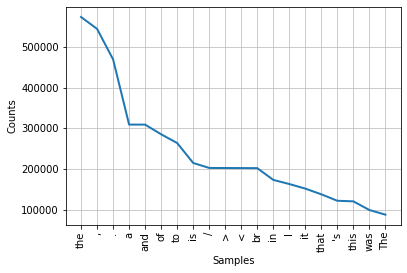

In [40]:
plot_freq_dist(review_words_pp, num_words=20)

In [45]:
wc2 = wordcloud.WordCloud(
    width=1000, 
    height=1000, 
    stopwords=stopwords,
    max_words=100,
    collocations=False
).generate(text=(' '.join(review_words_pp)).lower())

(-0.5, 999.5, 999.5, -0.5)

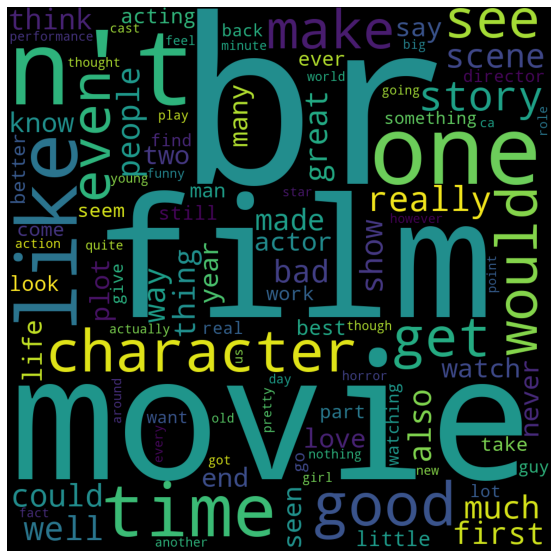

In [46]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.figure(figsize=[10,10])
plt.imshow(wc2)
plt.axis("off")

<div id="heading--5"/>

## 4. División de datos

A continuación vamos a dividir los datos entre train y test, usando una semilla para evitar la aletoriedad.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(review_post, sentimiento,test_size=0.20, random_state=2022)

<div id="heading--6"/>

## 5. Proceso de Tokenización

Antes de tirar cualquier modelo lo que vamos a hacer es realizar el proceso de tokenización de los datos.

In [47]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [48]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = 150 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

A continuación lo que haremos será crear un diccionario de embedding el cual nos resultará muy útil para los pesos de las diferentes redes:

In [49]:
def embeddings(path):
    embeddings_dictionary = dict()
    embeddings_file=open(path)
    for line in embeddings_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:],dtype='float32')
        embeddings_dictionary [word] = vector_dimensions
    embeddings_file.close()
    embedding_matrix = np.zeros((vocab_size, 100))
    
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    
    return embedding_matrix

<div id="heading--7"/>

## 6. Modelos

Una cosa que será bastante importante es la evaluación del modelo. Para ello definiremos un par de funciones que permitan sacar los resultados.

In [50]:
def evaluateModel(model):
    score = model.evaluate(X_test, y_test, verbose=1)
    print("Test Accuracy:", score[1])

In [51]:
def AccLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

Y a su vez también sacaremos la matriz de embedding usando el archivo de word2vec.

In [52]:
embedding_matrix = embeddings('./word2vec.txt')

A continuación ya comenzaremos a lanzar modelos, donde trabajaremos con redes neuronales simples, CNN, RNN + CNN y LTSM.

<div id="heading--5-1"/>

### 6.1. Red Neuronal Simple

In [53]:
random_state = 2022

In [54]:
model = keras.Sequential(
      [
          layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen , trainable=False),
          layers.Flatten(),
          layers.Dense(20,activation="sigmoid"),
          layers.Dropout(0.3),
          layers.Dense(10,activation = "sigmoid"),
          layers.Dropout(0.1),
          layers.Dense(5,activation = "sigmoid"),
          layers.Dense(1,activation="sigmoid")
      ]
  )

In [55]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [56]:
history = model.fit(x=X_train,y=y_train,batch_size=256,epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
125/125 [==============================] - 4s 27ms/step - loss: 0.6142 - acc: 0.7614 - val_loss: 0.5379 - val_acc: 0.8349
Epoch 2/10
125/125 [==============================] - 6s 47ms/step - loss: 0.4762 - acc: 0.8611 - val_loss: 0.4506 - val_acc: 0.8400
Epoch 3/10
125/125 [==============================] - 3s 25ms/step - loss: 0.3768 - acc: 0.8908 - val_loss: 0.4205 - val_acc: 0.8339
Epoch 4/10
125/125 [==============================] - 3s 25ms/step - loss: 0.3156 - acc: 0.9077 - val_loss: 0.4175 - val_acc: 0.8317
Epoch 5/10
125/125 [==============================] - 3s 25ms/step - loss: 0.2708 - acc: 0.9237 - val_loss: 0.4222 - val_acc: 0.8306
Epoch 6/10
125/125 [==============================] - 3s 25ms/step - loss: 0.2406 - acc: 0.9318 - val_loss: 0.4365 - val_acc: 0.8295
Epoch 7/10
125/125 [==============================] - 3s 26ms/step - loss: 0.2156 - acc: 0.9396 - val_loss: 0.4541 - val_acc: 0.8256
Epoch 8/10
125/125 [==============================] - 3s 26ms/step - 

In [57]:
evaluateModel(model)

313/313 [==============================] - 1s 3ms/step - loss: 0.4831 - acc: 0.8255
Test Accuracy: 0.8255000114440918


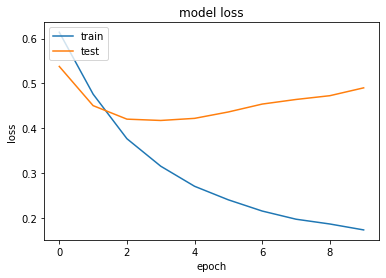

In [58]:
AccLoss(history)

<div id="heading--5-2"/>

### 6.2. CNN

In [59]:
random_state = 2022

In [60]:
model = keras.Sequential(
      [
          layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen),
          layers.Conv1D(filters=128,kernel_size=5,activation="relu"),
          layers.MaxPooling1D(),
          layers.Conv1D(filters=64,kernel_size=4,activation="relu"),
          layers.MaxPooling1D(),
          layers.Conv1D(filters=32,kernel_size=3,activation="relu"),
          layers.Flatten(),
          layers.Dense(25,activation="sigmoid"),
          layers.Dense(5,activation="sigmoid"),
          layers.Dense(1,activation="sigmoid"),
      ]
  )

In [61]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [62]:
history = model.fit(x=X_train,y=y_train,batch_size=128,epochs=5,verbose=1,validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 94s 375ms/step - loss: 0.4964 - acc: 0.8226 - val_loss: 0.4062 - val_acc: 0.8696
Epoch 2/5
250/250 [==============================] - 91s 365ms/step - loss: 0.3666 - acc: 0.8783 - val_loss: 0.3619 - val_acc: 0.8644
Epoch 3/5
250/250 [==============================] - 91s 363ms/step - loss: 0.3035 - acc: 0.9001 - val_loss: 0.3219 - val_acc: 0.8851
Epoch 4/5
250/250 [==============================] - 90s 360ms/step - loss: 0.2527 - acc: 0.9199 - val_loss: 0.3097 - val_acc: 0.8834
Epoch 5/5
250/250 [==============================] - 93s 371ms/step - loss: 0.2045 - acc: 0.9413 - val_loss: 0.3291 - val_acc: 0.8748


In [63]:
evaluateModel(model)

313/313 [==============================] - 6s 19ms/step - loss: 0.3127 - acc: 0.8832
Test Accuracy: 0.8831999897956848


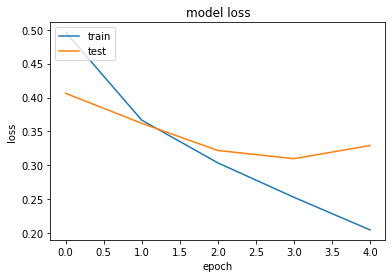

In [64]:
AccLoss(history)

<div id="heading--5-3"/>

### 6.3. RNN + CNN

In [65]:
random_state = 2022

In [66]:
model = keras.Sequential([
    layers.Embedding(vocab_size,100, weights=[embedding_matrix],input_length=maxlen),
    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=3),
    layers.LSTM(64),
    layers.Dense(1, activation='sigmoid')
    ])

In [67]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [68]:
history= model.fit(x=X_train,y=y_train,batch_size=128,epochs=5,verbose=1,validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 103s 404ms/step - loss: 0.3871 - acc: 0.8202 - val_loss: 0.3124 - val_acc: 0.8717
Epoch 2/5
250/250 [==============================] - 124s 496ms/step - loss: 0.2775 - acc: 0.8861 - val_loss: 0.2851 - val_acc: 0.8811
Epoch 3/5
250/250 [==============================] - 104s 418ms/step - loss: 0.2312 - acc: 0.9082 - val_loss: 0.2769 - val_acc: 0.8851
Epoch 4/5
250/250 [==============================] - 100s 401ms/step - loss: 0.1822 - acc: 0.9294 - val_loss: 0.2986 - val_acc: 0.8848
Epoch 5/5
250/250 [==============================] - 100s 399ms/step - loss: 0.1363 - acc: 0.9501 - val_loss: 0.3293 - val_acc: 0.8824


In [69]:
evaluateModel(model)

313/313 [==============================] - 8s 24ms/step - loss: 0.3206 - acc: 0.8856
Test Accuracy: 0.8855999708175659


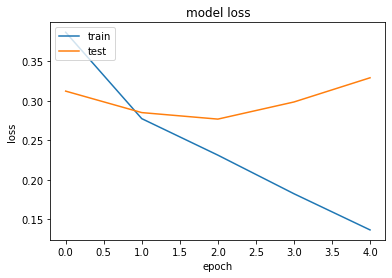

In [70]:
AccLoss(history)

<div id="heading--5-4"/>

### 6.4. LTSM

In [75]:
model = keras.Sequential(
      [
          layers.Embedding(vocab_size, 100, weights=[embedding_matrix],input_length=maxlen),
          layers.LSTM(64),
          layers.Dense(1,activation="sigmoid"),
      ]
  )

In [76]:
model.compile(loss='binary_crossentropy', optimizer='Adam',metrics='acc')

In [77]:
history= model.fit(x=X_train,y=y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 89s 350ms/step - loss: 0.6257 - acc: 0.6429 - val_loss: 0.6393 - val_acc: 0.6055
Epoch 2/6
250/250 [==============================] - 89s 357ms/step - loss: 0.5903 - acc: 0.6848 - val_loss: 0.6181 - val_acc: 0.6594
Epoch 3/6
250/250 [==============================] - 87s 346ms/step - loss: 0.5154 - acc: 0.7775 - val_loss: 0.4856 - val_acc: 0.8051
Epoch 4/6
250/250 [==============================] - 89s 357ms/step - loss: 0.4970 - acc: 0.7794 - val_loss: 0.6280 - val_acc: 0.6093
Epoch 5/6
250/250 [==============================] - 87s 347ms/step - loss: 0.4956 - acc: 0.7744 - val_loss: 0.5220 - val_acc: 0.7742
Epoch 6/6
250/250 [==============================] - 87s 347ms/step - loss: 0.4820 - acc: 0.7663 - val_loss: 0.4232 - val_acc: 0.8404


In [78]:
evaluateModel(model)

313/313 [==============================] - 8s 24ms/step - loss: 0.4275 - acc: 0.8387
Test Accuracy: 0.838699996471405


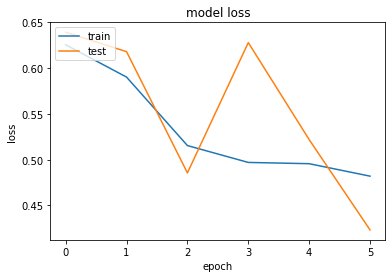

In [79]:
AccLoss(history)

<div id="heading--8"/>

## 7. Transformers

<div id="heading--9"/>

## 8. Comparaciones

<div id="heading--10"/>

## 9. Lineas de Investigación

Dentro de las posibles lineas de investigación podemos encontrar las siguientes ideas:

- Combinación de varios modelos sencillos que funcionen "bien" de forma individual.

- Aplicación de más tipos de transformers.

- Búsqueda de métodos innovadores dentro del mundo del NLP.